
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/")
!ls

In [1]:
%matplotlib inline

In [2]:
!pip install skorch
!pip install torch-summary==1.4.4

from __future__ import print_function, division
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

import torch.utils.data
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
plt.ion()   # interactive mode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 5.1 MB/s eta 0:00:0000:01


## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [3]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform
        print(self.class_to_idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create file for our preselection model

In [5]:
import os
import shutil
selected_classes = ['Oyster Omelette', 'Char Kway Teow', 'Bak Chor Mee', 'Chicken Rice', 'Nasi Lemak', 'Roti Prata']


def createfile(source_dir, target_dir_selected, target_dir_unselected, selected_classes):
    os.makedirs(target_dir_selected, exist_ok=True)
    os.makedirs(target_dir_unselected, exist_ok=True)

    for cls in os.listdir(source_dir):
        cls_dir = os.path.join(source_dir, cls)
        if os.path.isdir(cls_dir):
            if cls in selected_classes:
                target_dir = target_dir_selected
            else:
                target_dir = target_dir_unselected
            for filename in os.listdir(cls_dir):
                src_file = os.path.join(cls_dir, filename)
                if os.path.isfile(src_file):
                    shutil.copy(src_file, target_dir)
                    
source_dir = '/kaggle/input/sg-food/sg_food/train'
target_dir_selected = '/kaggle/working/train_/selected'
target_dir_unselected = '/kaggle/working/train_/unselected'
createfile(source_dir, target_dir_selected, target_dir_unselected, selected_classes)


source_dir = '/kaggle/input/sg-food/sg_food/val'
target_dir_selected = '/kaggle/working/val_/selected'
target_dir_unselected = '/kaggle/working/val_/unselected'
createfile(source_dir, target_dir_selected, target_dir_unselected, selected_classes)

source_dir = '/kaggle/input/sg-food/sg_food/test'
target_dir_selected = '/kaggle/working/test_/selected'
target_dir_unselected = '/kaggle/working/test_/unselected'
createfile(source_dir, target_dir_selected, target_dir_unselected, selected_classes)

# Data Augmentation

In [6]:
import random
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# additional_transforms = transforms.Compose([
#     A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
#     ToTensorV2(p=1.0)
# ])


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        
        transforms.Resize(232, interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        #additional_transforms,
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # ImageNet prior
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # ImageNet prior
    ]),
}

# Define dataset for preselection training

In [7]:
import os
from torchvision import datasets, transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        print(self.class_to_idx)
        self.samples = []
        
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(cls_dir):
                self.samples.append((os.path.join(cls_dir, file_name), self.class_to_idx[cls_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [10]:
from torchvision import datasets
data_dir_train = '/kaggle/working/train_'
data_dir_val = '/kaggle/working/val_'

image_datasets = {
    'train':CustomDataset(data_dir_train, data_transforms['train']),
    'val': CustomDataset(data_dir_val, data_transforms['val']),
}

pre_dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=0),
}
print(len(image_datasets['train']))

{'unselected': 0, 'selected': 1}
{'unselected': 0, 'selected': 1}
1200


# Useful Tricks
label smoothing
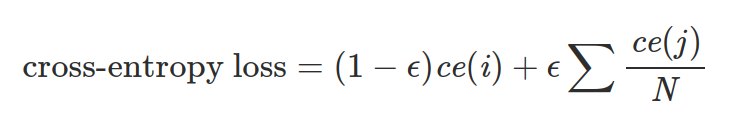

In [11]:
import torch.nn.functional as F

def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

Early stopping

In [12]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False

In [13]:
def train_model_1(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_acc = 0.0
    val_acc_history = []
    train_losses = []  # Average loss per epoch for training
    val_losses = []    # Average loss per epoch for validation
    loss_list = []     # Loss per iteration for more granularity

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Collect the loss and accuracy
                loss_list.append(loss.item()) if phase == 'train' else None
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # 如果调度器是 ReduceLROnPlateau 类型，则传递验证集上的指标值
                    if not val_losses:
                        val_loss = 10
                    else:
                        val_loss = val_losses[-1]  # 假设最新的验证损失值在列表中的最后一个位置
                    scheduler.step(val_loss)
                else:
                    # 对其他类型的调度器直接调用 step 方法
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            early_stopper = ValidationLossEarlyStopping(patience = 5, min_delta = 0.05)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if early_stopper.early_stop_check(epoch_loss):
                    print('Stop')
                    model.load_state_dict(best_model_wts)
                    break

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best so far in validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_acc_history, loss_list, best_acc


In [14]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification
# (code)
premodel_densenet = models.densenet121(pretrained=True)

# 2. Modify the pretrain model for your task.
num_ftrs = premodel_densenet.classifier.in_features
premodel_densenet.classifier = nn.Linear(num_ftrs, 2)
# (code)
premodel_densenet = premodel_densenet.to(device)

# 3. Choose your loss function, optimizer, etc.
# (code)
criterion = LabelSmoothingCrossEntropy()
optimizer_pre = optim.SGD(premodel_densenet.parameters(), lr=0.01, momentum=0.9)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer_pre, 'min')
#optimizer_pre = torch.optim.RMSprop(premodel_densenet.parameters(), lr=0.1)
#optimizer_pre = torch.optim.Adam(premodel_densenet.parameters(), lr = 0.01)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 143MB/s] 


In [15]:
scheduler_pre = lr_scheduler.StepLR(optimizer_pre, step_size=7, gamma=0.2)


premodel, train_losses_pre, val_losses_pre, val_acc_history_pre, loss_list_pre, best_acc_pre = train_model_1(
    model=premodel_densenet,
    dataloaders=pre_dataloaders,
    criterion=criterion,
    optimizer=optimizer_pre,
    scheduler=ReduceLR,  # Assuming you have defined scheduler above this line
    num_epochs=30
)

Epoch 1/30
----------
Train Loss: 0.9128 Acc: 0.6442
Val Loss: 2.1924 Acc: 0.6444
Epoch 2/30
----------
Train Loss: 0.9439 Acc: 0.7133
Val Loss: 1.3523 Acc: 0.7000
Epoch 3/30
----------
Train Loss: 0.7101 Acc: 0.7667
Val Loss: 0.8862 Acc: 0.6806
Epoch 4/30
----------
Train Loss: 0.5307 Acc: 0.8275
Val Loss: 0.8727 Acc: 0.7583
Epoch 5/30
----------
Train Loss: 0.5362 Acc: 0.8483
Val Loss: 0.9581 Acc: 0.7722
Epoch 6/30
----------
Train Loss: 0.4292 Acc: 0.8942
Val Loss: 0.5479 Acc: 0.8111
Epoch 7/30
----------
Train Loss: 0.3488 Acc: 0.9250
Val Loss: 0.4916 Acc: 0.8389
Epoch 8/30
----------
Train Loss: 0.3322 Acc: 0.9508
Val Loss: 0.5065 Acc: 0.8056
Epoch 9/30
----------
Train Loss: 0.3052 Acc: 0.9658
Val Loss: 0.6089 Acc: 0.8167
Epoch 10/30
----------
Train Loss: 0.3781 Acc: 0.9375
Val Loss: 0.5151 Acc: 0.8444
Epoch 11/30
----------
Train Loss: 0.2817 Acc: 0.9758
Val Loss: 0.4967 Acc: 0.8444
Epoch 12/30
----------
Train Loss: 0.2704 Acc: 0.9842
Val Loss: 0.4504 Acc: 0.8611
Epoch 13/30
-

In [16]:
test_dir = '/kaggle/working/test_'
# Define the test set.

image_datasets = {
    'test': CustomDataset(test_dir, data_transforms['val']),
}
test_sizes = len(image_datasets['test'])
pre_dataloaders = {
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=0),
}



{'unselected': 0, 'selected': 1}


In [17]:
from sklearn.metrics import confusion_matrix
premodel.eval()

test_acc = 0
num_classes = 2
conf_matrix = np.zeros((num_classes, num_classes))

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in pre_dataloaders['test']:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = premodel(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)
        conf_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=list(range(num_classes)))
# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Densenet Testing Acc: {:.4f}'.format(test_acc))
print(conf_matrix)
print('Recall:', conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[1][0]))
# accuracy_selected = correct_selected / total_selected if total_selected > 0 else 0
# print('Correct Selected number:', correct_selected)
# print('Total Selected number:', total_selected)
# print(f"Accuracy on selected class by the judge model: {accuracy_selected:.2f}")

Evaluation
----------
Densenet Testing Acc: 0.8771
[[1051.  149.]
 [ 146. 1054.]]
Recall: 0.8780284043441938


# Define Dataset for formal training

In [18]:
# Data augmentation and normalization for training
# Set seed for random, numpy, and torch operations

data_dir = os.path.join('/kaggle/input/sg-food/', 'sg_food')
#data_dir = os.path.join('/content/drive/MyDrive/DeepLearning_dataset', 'sg_food')
#data_dir = '/content/drive/MyDrive/DeepLearning_dataset/sg_food'
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [7,1,0,2,6,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))
train_dataset = image_datasets['train']
val_dataset = image_datasets['val']
# Define the dataloader
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
train_loader = dataloaders['train']
val_loader = dataloaders['val']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'Oyster Omelette': 0, 'Char Kway Teow': 1, 'Bak Chor Mee': 2, 'Chicken Rice': 3, 'Nasi Lemak': 4, 'Roti Prata': 5}
{'Oyster Omelette': 0, 'Char Kway Teow': 1, 'Bak Chor Mee': 2, 'Chicken Rice': 3, 'Nasi Lemak': 4, 'Roti Prata': 5}
selected classes:
    id: [7, 1, 0, 2, 6, 9]
    name: ['Oyster Omelette', 'Char Kway Teow', 'Bak Chor Mee', 'Chicken Rice', 'Nasi Lemak', 'Roti Prata']


In [19]:
print("trainset data:", dataset_sizes['train'])
print("valset data:", dataset_sizes['val'])

trainset data: 600
valset data: 180


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them.



In [20]:
from pathlib import Path
image_path = Path("/kaggle/input/sg-food/sg_food")
# Setup train and validation, testing paths
train_dir = image_path / "train"
val_dir  = image_path/"val"
test_dir  = image_path/"test"

# Get all image paths of images in train and val (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(len(image_path_list))

train_dir, val_dir, test_dir

3959


(PosixPath('/kaggle/input/sg-food/sg_food/train'),
 PosixPath('/kaggle/input/sg-food/sg_food/val'),
 PosixPath('/kaggle/input/sg-food/sg_food/test'))

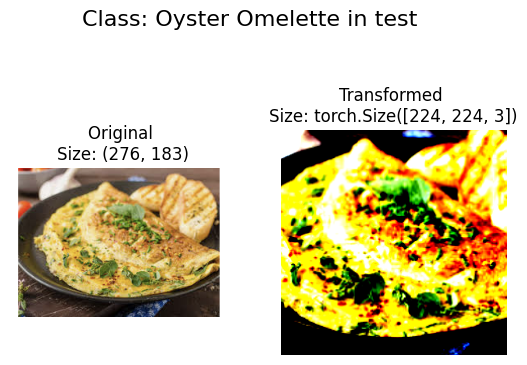

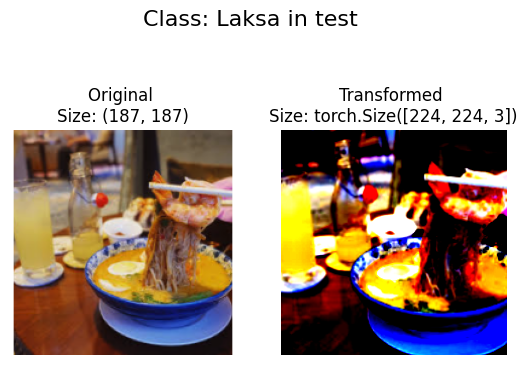

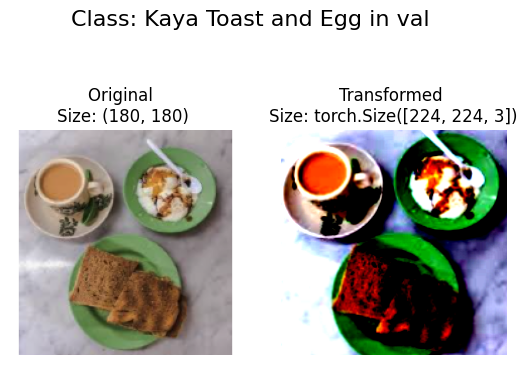

In [21]:
def plot_transformed_images(image_paths, transform, n=10, seed=42): 
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 66.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    category = ''
    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            if 'train' in str(image_path):
                transformed_image = transform['train'](f).permute(1, 2, 0)
                category='train'
            elif 'val' in str(image_path):
                transformed_image = transform['val'](f).permute(1, 2, 0)
                category='val'
            elif 'test' in str(image_path):
                transformed_image = transform['val'](f).permute(1, 2, 0)
                category='test'
            else:
                transformed_image = f

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            # transformed_image = transform(f).permute(1, 2, 0) 
            # transformed_image = transform['train'](f).permute(1, 2, 0)

            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem} in {category}", fontsize=16)


plot_transformed_images(image_path_list, 
                        transform=data_transforms, 
                        n=3)

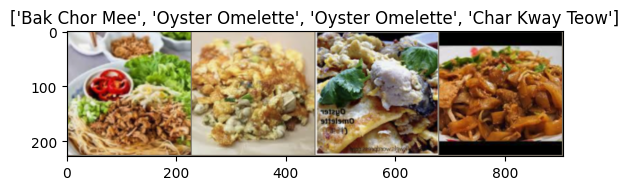

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [23]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
np.shape(images[0])

torch.Size([3, 224, 224])

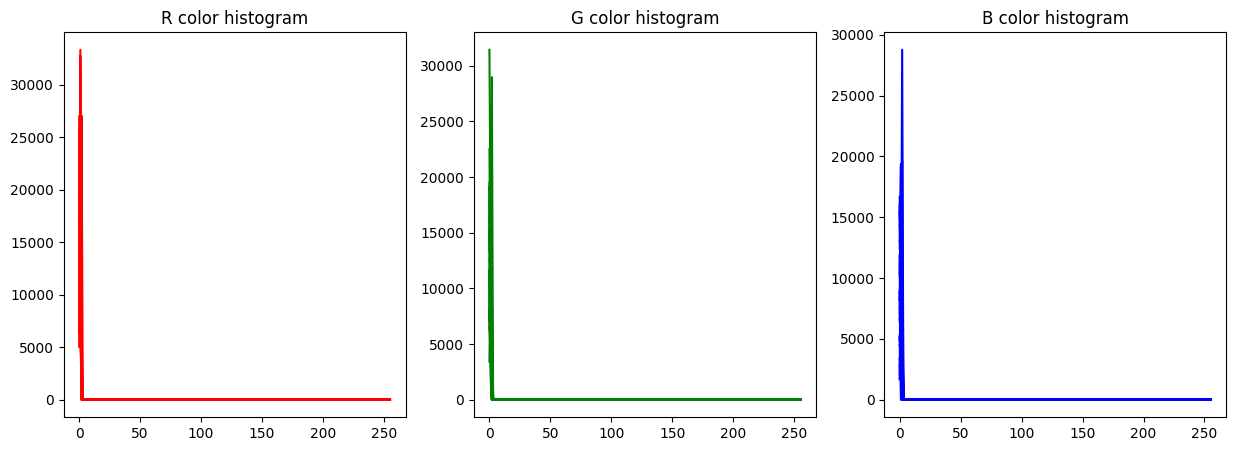

In [24]:
import cv2
# Code to plot color histograms for a batch of images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
color = ('r', 'g', 'b')
for i, col in enumerate(color):
    for img in inputs:
        histr = cv2.calcHist([img.cpu().numpy().transpose((1, 2, 0))], [i], None, [256], [0, 256])
        axes[i].plot(histr, color=col)
    axes[i].set_title(f'{col.upper()} color histogram')
plt.show()
#Overall, the histograms suggest that any image pre-processing for the classification task might
#include adjusting the brightness and contrast to ensure that the model is not biased towards learning from predominantly dark features.
#Ensuring a balanced exposure across the dataset can help improve model performance, especially if it currently has a bias towards darker images.

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [25]:
def train_model_2(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_acc = 0.0
    val_acc_history = []
    train_losses = []  # Average loss per epoch for training
    val_losses = []    # Average loss per epoch for validation
    loss_list = []     # Loss per iteration for more granularity

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Collect the loss and accuracy
                loss_list.append(loss.item()) if phase == 'train' else None
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # 如果调度器是 ReduceLROnPlateau 类型，则传递验证集上的指标值
                    if not val_losses:
                        val_loss = 10
                    else:
                        val_loss = val_losses[-1]  # 假设最新的验证损失值在列表中的最后一个位置
                    scheduler.step(val_loss)
                else:
                    # 对其他类型的调度器直接调用 step 方法
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            early_stopper = ValidationLossEarlyStopping(patience = 5, min_delta = 0.05)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if early_stopper.early_stop_check(epoch_loss):
                    print('Stop')
                    model.load_state_dict(best_model_wts)
                    break

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best so far in validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_acc_history, loss_list, best_acc


## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [26]:
bestacc = {}

#  renet34

In [27]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification
model_resnet34 = torchvision.models.resnet34(pretrained=True)
#for param in model_resnet34.parameters():
#    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_ftrs, 6)

model_resnet34 = model_resnet34.to(device)
model_resnet34_tuning = model_resnet34.to(device)

criterion = LabelSmoothingCrossEntropy()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 169MB/s]


### 4.2 Printing and visualizing the modified model

In [28]:
# TODO
print(model_resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# TODO

from torchsummary import summary
# in pretrained resnet34 documentation, the input image size is 224x224x3
summary(model_resnet34, input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

# HyperParameter Tuning
We use GridSearchCV to tuning the hyperparameters.

In [30]:
def gridsearch(model, train_dataloader):
    net = NeuralNetClassifier(
        model,
        criterion= LabelSmoothingCrossEntropy,
        optimizer=torch.optim.Adam,
        max_epochs=10,
        batch_size=64,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        iterator_train__shuffle=True
    )
    param_grid = {
        'lr': [0.01, 0.001],
        'max_epochs': [10, 20, 30],
        'optimizer':[torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]
    }
    gs = GridSearchCV(net, param_grid, cv=5, scoring='accuracy', verbose = 2)
    X_train = []
    y_train = []

    # Iterate over the training dataloader to extract X_train and y_train
    for batch in train_dataloader:
        inputs, labels = batch
        X_train.append(inputs)
        y_train.append(labels)

    # Concatenate the batches to form complete tensors for X_train and y_train
    X_train = torch.cat(X_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    # Train the model with grid search
    gs.fit(X_train, y_train)

    # Print the best score and parameters
    print("Best score:", gs.best_score_)
    print("Best parameters:", gs.best_params_)
    return gs.best_score_, gs.best_params_

In [31]:
#best_socre_res, best_params_res = gridsearch(model_resnet34_tuning, train_loader)

Best score: 0.712
Best parameters: {'lr': 0.001, 'max_epochs': 30, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

# ResNet34

In [32]:
# 3. Choose your loss function, optimizer, etc.
criterion = LabelSmoothingCrossEntropy()
learning_rate = 0.1
#optimizer_resnet34 = torch.optim.RMSprop(model_resnet34.fc.parameters(), lr=learning_rate)
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.SGD(model_resnet34.fc.parameters(), lr=0.001, momentum=0.9)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer_resnet34, 'min')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet34, step_size=5, gamma=0.1, verbose=2)
scheduler = [ReduceLR,exp_lr_scheduler]

Adjusting learning rate of group 0 to 1.0000e-01.


In [33]:
# TODO
# model_resnet18 = train_model(...)
# accuracy_list_resnet34, train_cost_resnet34, val_cost_resnet34=train_model(model=model_resnet34,
#                                                                        num_epochs=50,
#                                                                        train_loader=train_loader,
#                                                                        validation_loader=val_loader,
#                                                                        optimizer=optimizer,
#                                                                        scheduler = [ReduceLR, exp_lr_scheduler])
model_resnet34, train_losses_res, val_losses_res, val_acc_history_res, loss_list_res, best_acc_res34 = train_model_2(
    model=model_resnet34,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_resnet34,
    scheduler=exp_lr_scheduler,  # Assuming you have defined scheduler above this line
    num_epochs=15
)
bestacc['model_resnet34'] = best_acc_res34

Epoch 1/15
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Train Loss: 23.8172 Acc: 0.2750
Val Loss: 22.6285 Acc: 0.3556
Epoch 2/15
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Train Loss: 12.2800 Acc: 0.5733
Val Loss: 14.6705 Acc: 0.6389
Epoch 3/15
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Train Loss: 8.2187 Acc: 0.7583
Val Loss: 7.5184 Acc: 0.7111
Epoch 4/15
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Train Loss: 5.9183 Acc: 0.7950
Val Loss: 5.6877 Acc: 0.7944
Epoch 5/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 4.6807 Acc: 0.8433
Val Loss: 6.1235 Acc: 0.7056
Epoch 6/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 3.4953 Acc: 0.9000
Val Loss: 5.4156 Acc: 0.7444
Epoch 7/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 3.2287 Acc: 0.9217
Val Loss: 4.7132 Acc: 0.8056
Epoch 8/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.


# vgg16

In [34]:
from torchvision.models import vgg16, VGG16_Weights
# Load the pretrained VGG16 model with updated weights parameter
model_vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# 2. Modify the pretrain model for your task.
# for param in model_vgg16.parameters():
#     param.requires_grad = False
# 4.1.2 Modify the pretrained model for your task.
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(selected_classes))  # Replace with the number of classes in your dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16 = model_vgg16.to(device)
# 3. Choose your loss function, optimizer, etc.

# 4.1.3 Choose your loss function, optimizer, etc.
criterion = LabelSmoothingCrossEntropy()
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)
#optimizer_vgg16 = torch.optim.RMSprop(model_vgg16.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 172MB/s]  


In [35]:
summary(model_vgg16, input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [36]:
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size=5, gamma=0.1, verbose=True )

Adjusting learning rate of group 0 to 1.0000e-02.


In [37]:
model_vgg16, train_losses_vgg16, val_losses_vgg16, val_acc_history_vgg16, loss_list_vgg16, best_acc_vgg16 = train_model_2(
    model=model_vgg16,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_vgg16,
    scheduler=exp_lr_scheduler_vgg16,  # Assuming you have defined scheduler above this line
    num_epochs=25
)
bestacc['model_vgg16'] = best_acc_vgg16

Epoch 1/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.5449 Acc: 0.4167
Val Loss: 1.7358 Acc: 0.3056
Epoch 2/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.7437 Acc: 0.3233
Val Loss: 1.7274 Acc: 0.2389
Epoch 3/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.6648 Acc: 0.3150
Val Loss: 1.6603 Acc: 0.3222
Epoch 4/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.5951 Acc: 0.3533
Val Loss: 1.4518 Acc: 0.4333
Epoch 5/20
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.3981 Acc: 0.4983
Val Loss: 1.2798 Acc: 0.5611
Epoch 6/20
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.1301 Acc: 0.6767
Val Loss: 1.0972 Acc: 0.7000
Epoch 7/20
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.9486 Acc: 0.7733
Val Loss: 1.0288 Acc: 0.7000
Epoch 8/20
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Trai

# Densnet

In [38]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification
# (code)
model_densenet = models.densenet121(pretrained=True)

# 2. Modify the pretrain model for your task.
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, len(selected_classes))
# (code)
model_densenet = model_densenet.to(device)

# 3. Choose your loss function, optimizer, etc.
# (code)
criterion = LabelSmoothingCrossEntropy()
optimizer_dens = optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
print(model_densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [40]:
summary(model_densenet, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [41]:
scheduler_dens = lr_scheduler.StepLR(optimizer_dens, step_size=7, gamma=0.1)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer_dens, 'min')

model_densenet, train_losses_den, val_losses_den, val_acc_history_den, loss_list_den, best_acc_densenet = train_model_2(
    model=model_densenet,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_dens,
    scheduler=ReduceLR,  # Assuming you have defined scheduler above this line
    num_epochs=20
)
bestacc['model_densenet'] = best_acc_densenet

Epoch 1/20
----------
Train Loss: 1.7549 Acc: 0.2450
Val Loss: 1.5354 Acc: 0.5167
Epoch 2/20
----------
Train Loss: 1.2892 Acc: 0.7100
Val Loss: 1.1911 Acc: 0.6833
Epoch 3/20
----------
Train Loss: 0.9451 Acc: 0.8467
Val Loss: 0.9794 Acc: 0.7500
Epoch 4/20
----------
Train Loss: 0.7675 Acc: 0.8933
Val Loss: 0.8670 Acc: 0.8389
Epoch 5/20
----------
Train Loss: 0.6526 Acc: 0.9417
Val Loss: 0.7935 Acc: 0.8556
Epoch 6/20
----------
Train Loss: 0.5925 Acc: 0.9600
Val Loss: 0.7693 Acc: 0.8833
Epoch 7/20
----------
Train Loss: 0.5691 Acc: 0.9783
Val Loss: 0.7557 Acc: 0.8722
Epoch 8/20
----------
Train Loss: 0.5425 Acc: 0.9817
Val Loss: 0.7444 Acc: 0.8889
Epoch 9/20
----------
Train Loss: 0.5142 Acc: 0.9933
Val Loss: 0.7345 Acc: 0.9000
Epoch 10/20
----------
Train Loss: 0.4946 Acc: 0.9967
Val Loss: 0.7269 Acc: 0.9056
Epoch 11/20
----------
Train Loss: 0.4833 Acc: 1.0000
Val Loss: 0.7244 Acc: 0.9000
Epoch 12/20
----------
Train Loss: 0.4775 Acc: 1.0000
Val Loss: 0.7216 Acc: 0.9056
Epoch 13/20
-

# GoogLeNet

In [42]:
# Importing GoogLeNet
from torchvision.models import googlenet

# Initialize GoogLeNet model
model_googlenet = models.googlenet(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 95.2MB/s]


In [43]:
model_googlenet = models.googlenet(pretrained=True)

num_ftrs = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(num_ftrs, len(selected_classes))
model_googlenet = model_googlenet.to(device)

In [44]:
summary(model_googlenet, input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       4,096
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  384
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             110,848
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             3,104
|    |    └─BasicConv2d: 3-6            

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       4,096
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  384
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             110,848
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             3,104
|    |    └─BasicConv2d: 3-6            

In [45]:
# Set up optimizer and scheduler
optimizer_goog = optim.SGD(model_googlenet.parameters(), lr=0.01, momentum=0.9)
scheduler_goog = lr_scheduler.StepLR(optimizer_goog, step_size=7, gamma=0.1)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer_goog, 'min')

# Train the model
model_googlenet, train_losses_googlenet, val_losses_googlenet, val_acc_history_googlenet, loss_list_googlenet, best_acc_googlenet = train_model_2(
    model=model_googlenet,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_goog,
    scheduler=ReduceLR,
    num_epochs=20
)
bestacc['model_googlenet'] = best_acc_googlenet

Epoch 1/20
----------
Train Loss: 1.6272 Acc: 0.3467
Val Loss: 1.2356 Acc: 0.5944
Epoch 2/20
----------
Train Loss: 0.9638 Acc: 0.7667
Val Loss: 1.0336 Acc: 0.7611
Epoch 3/20
----------
Train Loss: 0.6867 Acc: 0.9083
Val Loss: 0.8186 Acc: 0.8667
Epoch 4/20
----------
Train Loss: 0.5726 Acc: 0.9667
Val Loss: 0.8005 Acc: 0.8556
Epoch 5/20
----------
Train Loss: 0.5083 Acc: 0.9917
Val Loss: 0.7692 Acc: 0.8500
Epoch 6/20
----------
Train Loss: 0.4826 Acc: 0.9983
Val Loss: 0.7706 Acc: 0.8556
Epoch 7/20
----------
Train Loss: 0.4801 Acc: 0.9983
Val Loss: 0.7592 Acc: 0.8889
Epoch 8/20
----------
Train Loss: 0.4649 Acc: 1.0000
Val Loss: 0.7348 Acc: 0.8889
Epoch 9/20
----------
Train Loss: 0.4659 Acc: 1.0000
Val Loss: 0.7261 Acc: 0.8944
Epoch 10/20
----------
Train Loss: 0.4662 Acc: 1.0000
Val Loss: 0.7609 Acc: 0.8944
Epoch 11/20
----------
Train Loss: 0.4688 Acc: 1.0000
Val Loss: 0.7655 Acc: 0.8722
Epoch 12/20
----------
Train Loss: 0.4546 Acc: 1.0000
Val Loss: 0.7365 Acc: 0.8944
Epoch 13/20
-

# Efficientnet

In [46]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_eff = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


In [47]:
# Parameters of newly constructed modules have requires_grad=True by default
# for param in model_eff.parameters():
#     param.requires_grad = False
# Recreate the classifier layer and seed it to the target device
model_eff.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=n_classes, # n-class classification
                    bias=True)).to(device)

model_eff_tuning = model_eff

In [48]:
summary(model_eff, input_size=(3,224,224))

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       1,448
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       6,004
|    |    └─MBConv: 3-6                       10,710
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       15,350
|    |    └─MBConv: 3-8                       31,290
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       37,130
|    |    └─MBConv: 3-10                      102,900
|    |    └─MBConv: 3-11                      102,900
|    └─Sequential: 2-6                        --
|    |    └─MBConv: 3-12       

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       1,448
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       6,004
|    |    └─MBConv: 3-6                       10,710
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       15,350
|    |    └─MBConv: 3-8                       31,290
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       37,130
|    |    └─MBConv: 3-10                      102,900
|    |    └─MBConv: 3-11                      102,900
|    └─Sequential: 2-6                        --
|    |    └─MBConv: 3-12       

In [49]:
# 3. Choose your loss function, optimizer, etc.
criterion = LabelSmoothingCrossEntropy()
learning_rate = 0.01
# optimizer = torch.optim.Adam(model_eff.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model_eff.parameters(), lr=learning_rate,momentum=0.9)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1,verbose=2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1,verbose=2)
ReduceLR = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Adjusting learning rate of group 0 to 1.0000e-02.


In [50]:
# TODO
model_eff, train_losses_eff, val_losses_eff, val_acc_history_eff, loss_list_eff, best_acc_eff =train_model_2(model=model_eff,
                                                                       num_epochs=30,
                                                                       dataloaders=dataloaders,                                                
                                                                       optimizer=optimizer,
                                                                       criterion = criterion,
                                                                       scheduler = ReduceLR)

Epoch 1/30
----------
Train Loss: 1.5856 Acc: 0.4383
Val Loss: 1.1154 Acc: 0.7500
Epoch 2/30
----------
Train Loss: 0.8844 Acc: 0.8467
Val Loss: 0.8205 Acc: 0.8611
Epoch 3/30
----------
Train Loss: 0.6379 Acc: 0.9450
Val Loss: 0.7595 Acc: 0.8889
Epoch 4/30
----------
Train Loss: 0.5494 Acc: 0.9800
Val Loss: 0.7435 Acc: 0.8833
Epoch 5/30
----------
Train Loss: 0.5107 Acc: 0.9933
Val Loss: 0.7330 Acc: 0.8944
Epoch 6/30
----------
Train Loss: 0.4986 Acc: 0.9983
Val Loss: 0.7214 Acc: 0.9000
Epoch 7/30
----------
Train Loss: 0.4837 Acc: 1.0000
Val Loss: 0.7023 Acc: 0.8944
Epoch 8/30
----------
Train Loss: 0.4761 Acc: 1.0000
Val Loss: 0.6975 Acc: 0.9056
Epoch 9/30
----------
Train Loss: 0.4687 Acc: 0.9983
Val Loss: 0.6957 Acc: 0.8944
Epoch 10/30
----------
Train Loss: 0.4733 Acc: 0.9983
Val Loss: 0.6866 Acc: 0.9056
Epoch 11/30
----------
Train Loss: 0.4697 Acc: 1.0000
Val Loss: 0.6928 Acc: 0.8944
Epoch 12/30
----------
Train Loss: 0.4668 Acc: 0.9983
Val Loss: 0.6906 Acc: 0.9000
Epoch 13/30
-

In [51]:
bestacc['model_eff'] = best_acc_eff

# Squeeze Net

In [52]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_squeezenet1_1 = models.squeezenet1_1(pretrained=True)

# 2. Modify the pretrain model for your task.

model_squeezenet1_1.classifier[1] = nn.Conv2d(512, n_classes, kernel_size=(1,1))

# 3. Choose your loss function, optimizer, etc.

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model_squeezenet1_1.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 63.9MB/s]


In [53]:
summary(model_squeezenet1_1)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Fire: 2-4                         --
|    |    └─Conv2d: 3-1                  1,040
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  1,088
|    |    └─ReLU: 3-4                    --
|    |    └─Conv2d: 3-5                  9,280
|    |    └─ReLU: 3-6                    --
|    └─Fire: 2-5                         --
|    |    └─Conv2d: 3-7                  2,064
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  1,088
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 9,280
|    |    └─ReLU: 3-12                   --
|    └─MaxPool2d: 2-6                    --
|    └─Fire: 2-7                         --
|    |    └─Conv2d: 3-13                 4,128
|  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Fire: 2-4                         --
|    |    └─Conv2d: 3-1                  1,040
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  1,088
|    |    └─ReLU: 3-4                    --
|    |    └─Conv2d: 3-5                  9,280
|    |    └─ReLU: 3-6                    --
|    └─Fire: 2-5                         --
|    |    └─Conv2d: 3-7                  2,064
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  1,088
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 9,280
|    |    └─ReLU: 3-12                   --
|    └─MaxPool2d: 2-6                    --
|    └─Fire: 2-7                         --
|    |    └─Conv2d: 3-13                 4,128
|  

In [54]:
# TODO
model_squeezenet1_1, train_losses_sq, val_losses_sq, val_acc_history_sq, loss_list_sq, best_acc_sq =train_model_2(model=model_squeezenet1_1,
                                                                       num_epochs=20,
                                                                       dataloaders=dataloaders,                                                
                                                                       optimizer=optimizer,
                                                                       criterion = criterion,
                                                                       scheduler = exp_lr_scheduler)

bestacc['model_squeezenet1_1'] = best_acc_sq

Epoch 1/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.8533 Acc: 0.2367
Val Loss: 1.6955 Acc: 0.2389
Epoch 2/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.5562 Acc: 0.4217
Val Loss: 1.2987 Acc: 0.6056
Epoch 3/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.2563 Acc: 0.6050
Val Loss: 1.2703 Acc: 0.5889
Epoch 4/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 1.0885 Acc: 0.6733
Val Loss: 1.0711 Acc: 0.7167
Epoch 5/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 0.9627 Acc: 0.7533
Val Loss: 1.1918 Acc: 0.6389
Epoch 6/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 0.8917 Acc: 0.7967
Val Loss: 1.1157 Acc: 0.6667
Epoch 7/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Train Loss: 0.7983 Acc: 0.8650
Val Loss: 1.0433 Acc: 0.7556
Epoch 8/20
----------
Adjusting learning rate of group 0 to 1.0000e-02.
Trai

## 5. Loading test data

Define the dataset and dataloader for testing.

In [55]:
test_dir = os.path.join('/kaggle/input/sg-food/', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

{'Oyster Omelette': 0, 'Char Kway Teow': 1, 'Bak Chor Mee': 2, 'Chicken Rice': 3, 'Nasi Lemak': 4, 'Roti Prata': 5}


In [56]:
print(len(test_loader))

38


## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

In [57]:
# TODO
def visualize(model, num_images):
# num_images = 4 (increase for better analysis)
    num_images = 5

    # Make sure to use the model and test_loader you have defined in your previous sections
    model.eval()  # Set the model to evaluation mode

    # Get a batch of test data
    images, labels = next(iter(test_loader))

    # Move the images and labels to the appropriate device
    images, labels = images.to(device), labels.to(device)

    # with torch.no_grad():
    with torch.no_grad():  # No need to track the gradients

        # Predict on the test set
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Print the output images and labels
        fig = plt.figure(figsize=(15, 4))

        for idx in range(num_images):
          ax = fig.add_subplot(1, num_images, idx+1, xticks=[], yticks=[])
          # Convert image from Torch tensor to numpy for plotting
          img = images[idx].cpu().numpy().transpose((1, 2, 0))
          img = std * img + mean  # Unnormalize
          img = np.clip(img, 0, 1)  # Clip to the valid range [0,1]
          ax.imshow(img)
          ax.set_title(f'Predicted: {class_names[preds[idx]]}\nActual: {class_names[labels[idx]]}')



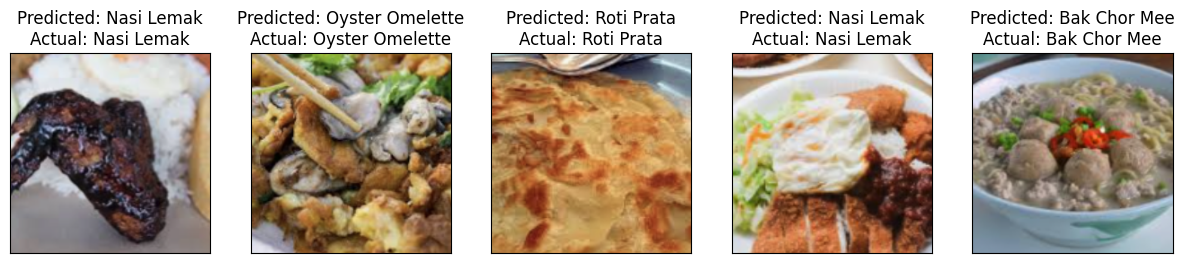

In [58]:
visualize(model_resnet34, 5)

plt.ioff()
plt.show()

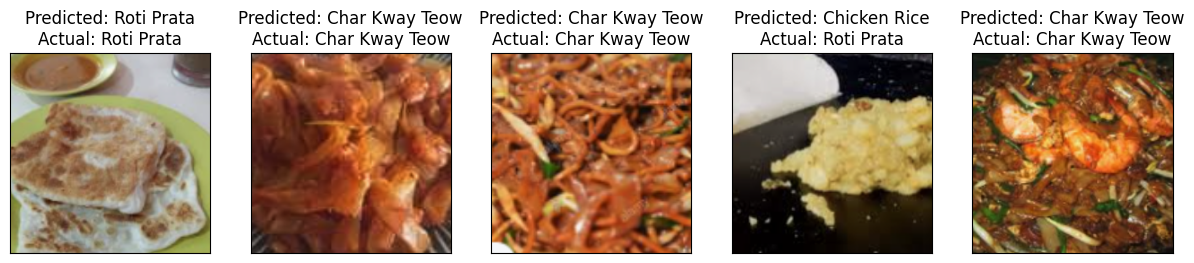

In [59]:
visualize(model_vgg16, 5)
plt.ioff()
plt.show()

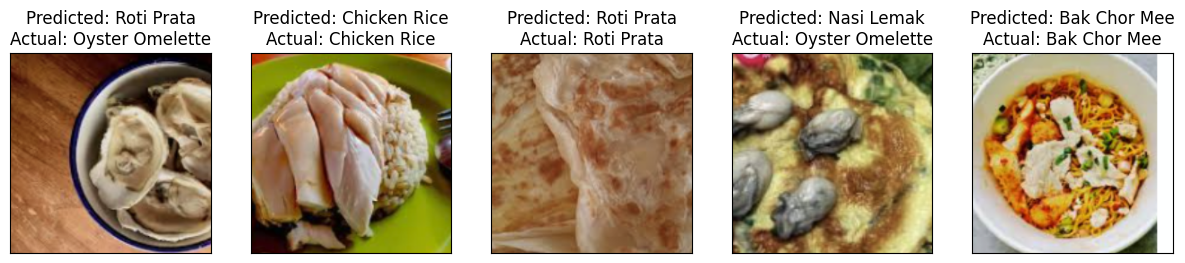

In [60]:
visualize(model_densenet, 5)
plt.ioff()
plt.show()

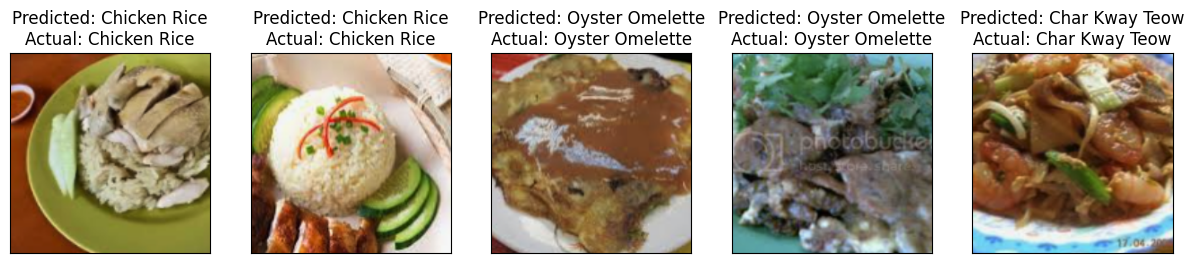

In [61]:
visualize(model_googlenet, 5)
plt.ioff()
plt.show()

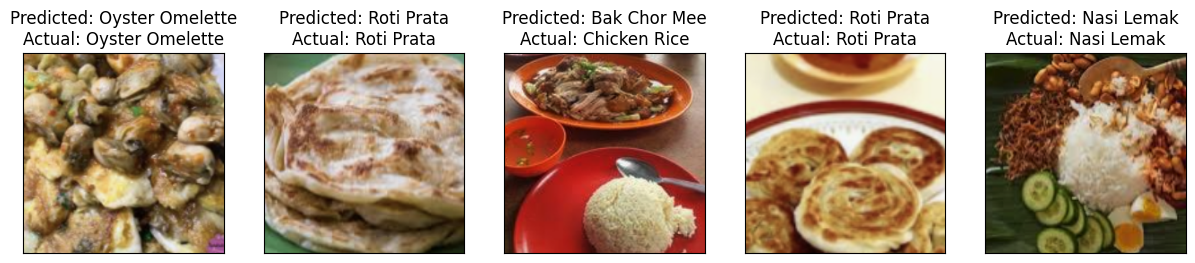

In [62]:
visualize(model_squeezenet1_1, 5)
plt.ioff()
plt.show()

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [63]:
model_resnet34.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet34(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('ResNet34 Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
ResNet34 Testing Acc: 0.7617


In [64]:
model_vgg16.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('VGG16 Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
VGG16 Testing Acc: 0.8025


In [65]:
model_densenet.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_densenet(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Densenet Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Densenet Testing Acc: 0.8592


In [66]:
model_googlenet.eval()
    
test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_googlenet(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('GoogLeNet Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
GoogLeNet Testing Acc: 0.8467


In [67]:
model_eff.eval()
    
test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_eff(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('EfficientNet Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
EfficientNet Testing Acc: 0.8667


In [68]:
model_squeezenet1_1.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_squeezenet1_1(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Squeeze Net Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Squeeze Net Testing Acc: 0.7808


# Ploting

In [69]:
def loss_plot(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss per Iteration')
    plt.show()

In [70]:
def lossvsiter(loss_list):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, color='blue', label='Loss per Iteration')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.title('Loss Function vs Iteration Number')
    plt.legend()
    plt.show()

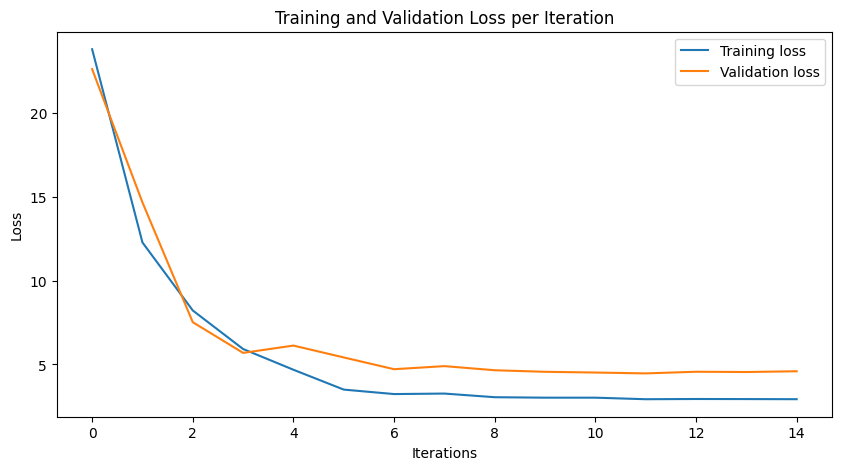

In [71]:
loss_plot(train_losses_res, val_losses_res)

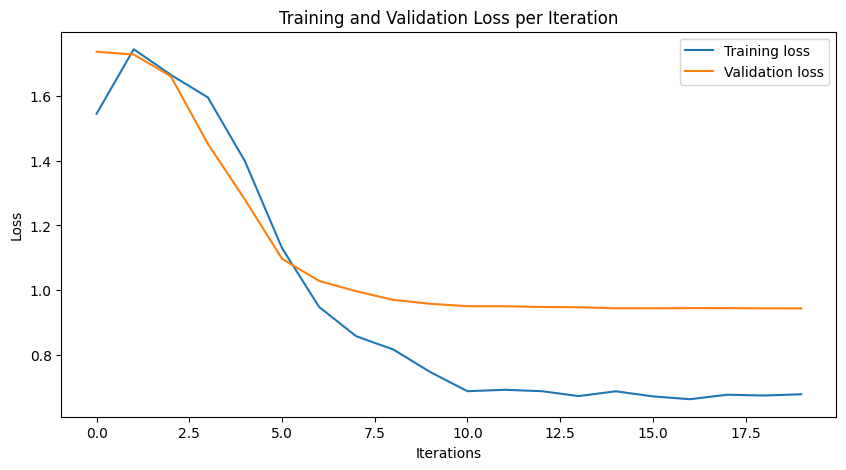

In [72]:
loss_plot(train_losses_vgg16, val_losses_vgg16)

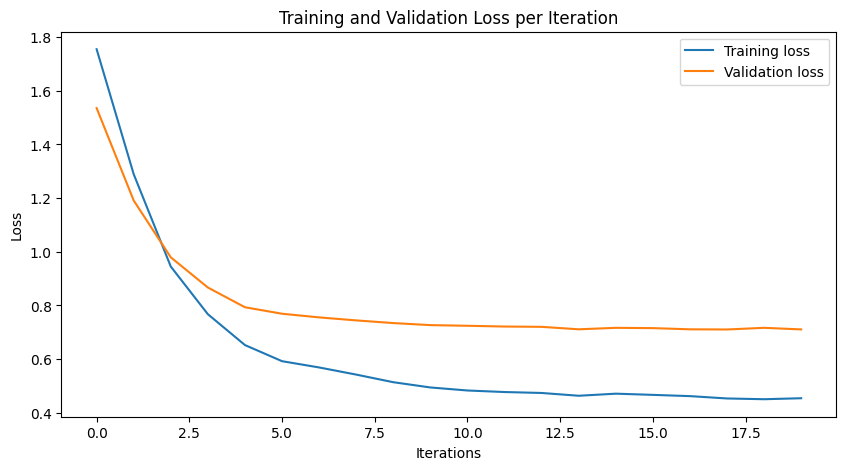

In [73]:
loss_plot(train_losses_den, val_losses_den)

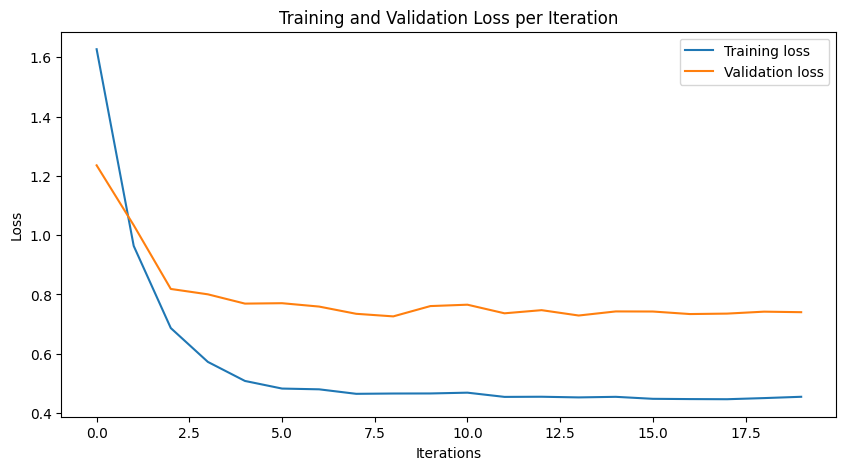

In [74]:
loss_plot(train_losses_googlenet, val_losses_googlenet)

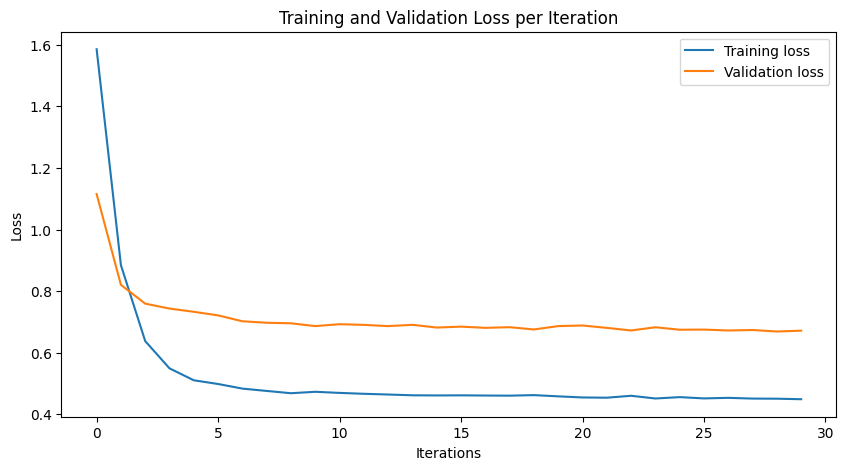

In [75]:
loss_plot(train_losses_eff, val_losses_eff)

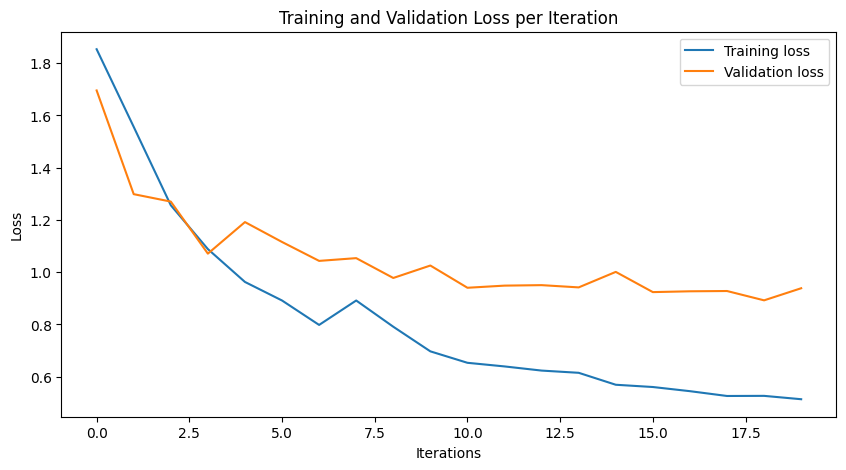

In [76]:
loss_plot(train_losses_sq, val_losses_sq)

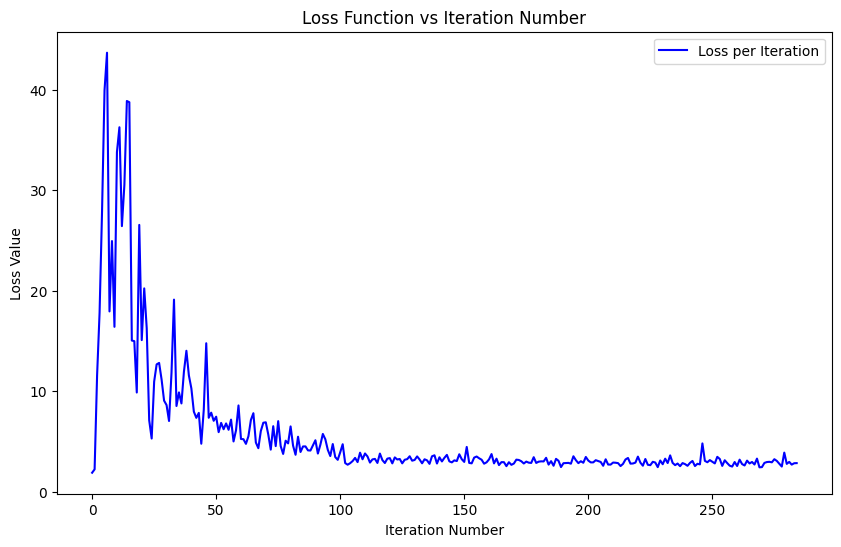

In [77]:
lossvsiter(loss_list_res)

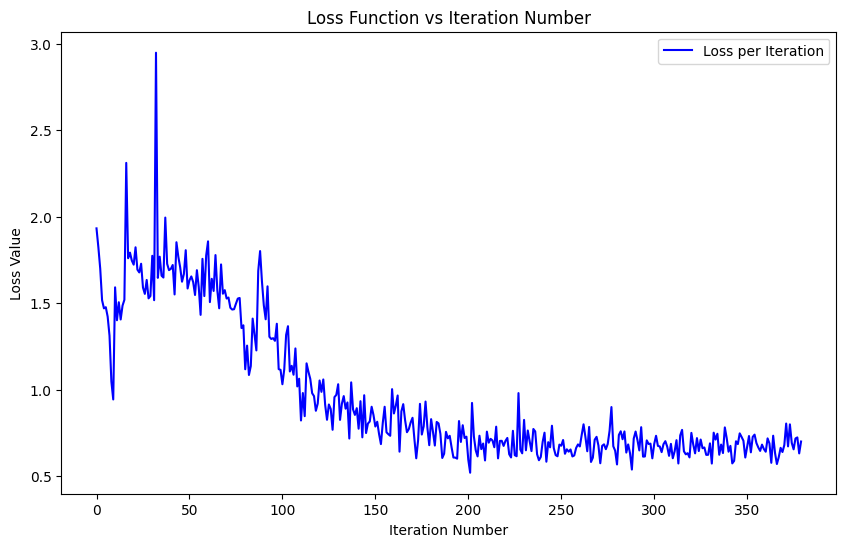

In [78]:
lossvsiter(loss_list_vgg16)

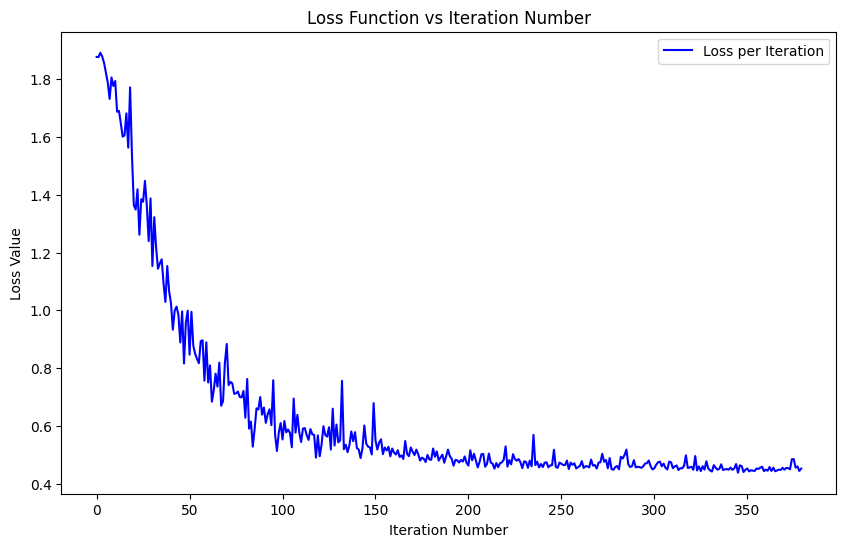

In [79]:
lossvsiter(loss_list_den)

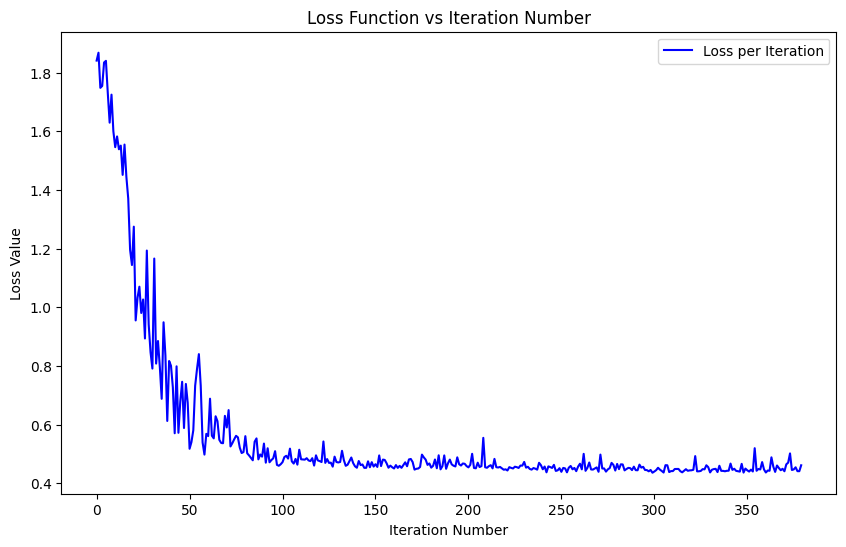

In [80]:
lossvsiter(loss_list_googlenet)

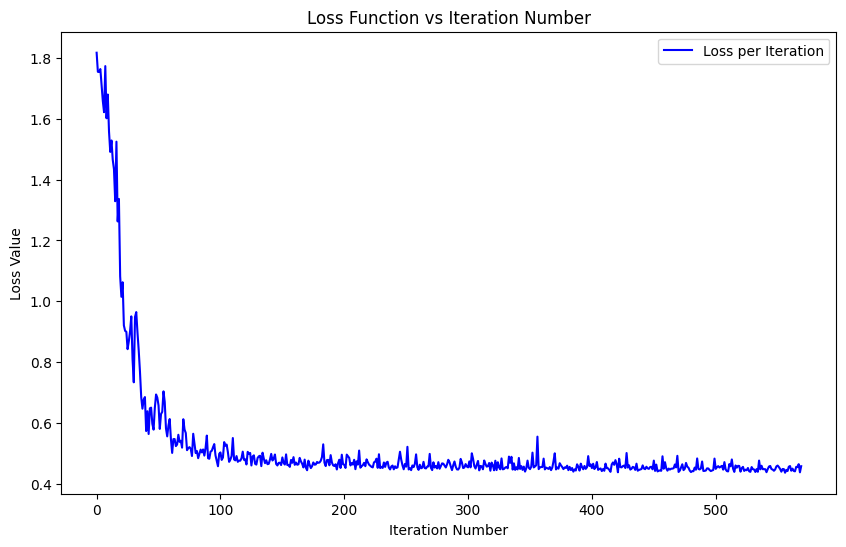

In [81]:
lossvsiter(loss_list_eff)

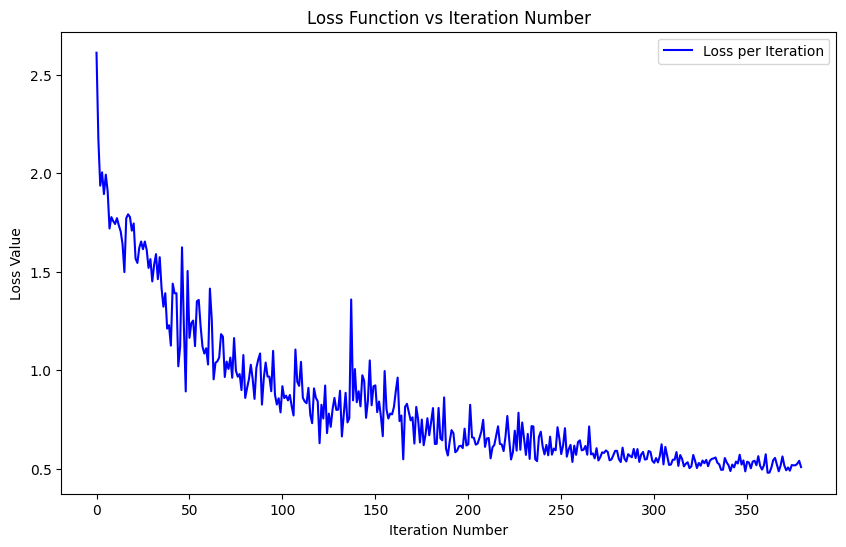

In [82]:
lossvsiter(loss_list_sq)

# Ensemble

In [83]:
# Convert tensor values to a single tensor
tensor_values = torch.stack(list(bestacc.values()))

# Compute softmax probabilities
softmax_probs = torch.softmax(tensor_values, dim=0)

# Normalize softmax probabilities to sum up to 1
normalized_probs = softmax_probs / softmax_probs.sum()

# Create a dictionary with keys and normalized probabilities
weights_dict = {key: value.item() for key, value in zip(bestacc.keys(), normalized_probs)}

print(weights_dict)


{'model_resnet34': 0.15914914947043635, 'model_vgg16': 0.15393161974582334, 'model_densenet': 0.1758870116312006, 'model_googlenet': 0.17491257085279927, 'model_eff': 0.1778522093072617, 'model_squeezenet1_1': 0.15826743899247872}


In [85]:
import torch.nn.functional as F

correct = 0
correct_weighted = 0
total = 0
true_labels = []
combined_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        true_labels.extend(labels.cpu().tolist())
        outputs_resnet34 = model_resnet34(inputs)
        probs_resnet34 = F.softmax(outputs_resnet34, dim=1)
        
        
        # Forward pass through VGG16
        outputs_vgg16 = model_vgg16(inputs)
        probs_vgg16 = F.softmax(outputs_vgg16, dim=1)
        
        outputs_densenet = model_densenet(inputs)
        probs_densenet = F.softmax(outputs_densenet, dim=1)
        
        outputs_goog = model_googlenet(inputs)
        probs_goog = F.softmax(outputs_goog, dim=1)
        
        outpus_eff = model_eff(inputs)
        probs_eff = F.softmax(outputs_goog, dim=1)
        
        outpus_sq = model_squeezenet1_1(inputs)
        probs_sq = F.softmax(outpus_sq, dim=1)
        
        #avg_probs = (probs_resnet34 + probs_vgg16 + probs_resnet50 + probs_densenet + probs_goog) / 5
        avg_probs = (probs_resnet34 + probs_vgg16 + probs_densenet + probs_goog + probs_eff + probs_sq) / 6
        
        # Make decision based on the combined probabilities
        _, combined_prediction = torch.max(avg_probs, dim=1)

       # Update total count
        total += labels.size(0)
        
        # Update correct count
        correct += (combined_prediction == labels).sum().item()
        
        # Apply weights to probabilities
        probs_resnet34_weighted = probs_resnet34 * weights_dict['model_resnet34']
        probs_vgg16_weighted = probs_vgg16 * weights_dict['model_vgg16']
        probs_densenet_weighted = probs_densenet * weights_dict['model_densenet']
        probs_goog_weighted = probs_goog * weights_dict['model_googlenet']
        probs_eff_weighted = probs_eff * weights_dict['model_eff']
        probs_sq_weighted = probs_sq * weights_dict['model_squeezenet1_1']
        
        # Combine probabilities with weighted average
        weighted_probs = (probs_resnet34_weighted + probs_vgg16_weighted + probs_densenet_weighted + 
                     probs_goog_weighted + probs_eff_weighted + probs_sq_weighted)
        
        # Make decision based on the combined probabilities
        _, combined_prediction2 = torch.max(weighted_probs, dim=1)
        
        # Update correct count
        correct_weighted += (combined_prediction2 == labels).sum().item()

        

# Calculate accuracy
accuracy = correct / total
print('Average Voting Accuracy: {:.2f}%'.format(100 * accuracy))
accuracy_weighted = correct_weighted / total
print('Weights dict:', weights_dict)
print('\n Weighted Voting Accuracy: {:.2f}%'.format(100 * accuracy_weighted))

Average Voting Accuracy: 87.50%
Weights dict: {'model_resnet34': 0.15914914947043635, 'model_vgg16': 0.15393161974582334, 'model_densenet': 0.1758870116312006, 'model_googlenet': 0.17491257085279927, 'model_eff': 0.1778522093072617, 'model_squeezenet1_1': 0.15826743899247872}

 Weighted Voting Accuracy: 87.67%


In [ ]:
import torch.nn.functional as F

correct = 0
total = 0
true_labels = []
combined_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        true_labels.extend(labels.cpu().tolist())
        
        outputs_resnet34 = model_resnet34(inputs)
        probs_resnet34 = F.softmax(outputs_resnet34, dim=1)
        
        outputs_resnet50 = model_resnet50(inputs)
        probs_resnet50 = F.softmax(outputs_resnet50, dim=1)
        
        outputs_vgg16 = model_vgg16(inputs)
        probs_vgg16 = F.softmax(outputs_vgg16, dim=1)
        
        outputs_densenet = model_densenet(inputs)
        probs_densenet = F.softmax(outputs_densenet, dim=1)
        
        outputs_goog = model_googlenet(inputs)
        probs_goog = F.softmax(outputs_goog, dim=1)
        
        outpus_eff = model_eff(inputs)
        probs_eff = F.softmax(outputs_goog, dim=1)
        
        outpus_sq = model_squeezenet1_1(inputs)
        probs_sq = F.softmax(outpus_sq, dim=1)
        
        # Apply weights to probabilities
        probs_resnet34_weighted = probs_resnet34 * weights_dict['model_resnet34']
        probs_resnet50_weighted = probs_resnet50 * weights_dict['model_resnet50']
        probs_vgg16_weighted = probs_vgg16 * weights_dict['model_vgg16']
        probs_densenet_weighted = probs_densenet * weights_dict['model_densenet']
        probs_goog_weighted = probs_goog * weights_dict['model_googlenet']
        probs_eff_weighted = probs_eff * weights_dict['model_eff']
        probs_sq_weighted = probs_sq * weights_dict['model_squeezenet1_1']
        
        # Combine probabilities with weighted average
        avg_probs = (probs_resnet34_weighted + probs_vgg16_weighted + 
                     probs_resnet50_weighted + probs_densenet_weighted + 
                     probs_goog_weighted + probs_eff_weighted + probs_sq_weighted)
        
        # Make decision based on the combined probabilities
        _, combined_prediction = torch.max(avg_probs, dim=1)

        # Update total count
        total += labels.size(0)
        
        # Update correct count
        correct += (combined_prediction == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print('Weights dict:', weights_dict)
print('\nAccuracy: {:.2f}%'.format(100 * accuracy))


In [ ]:
sorted_dict = dict(sorted(bestacc.items(), key=lambda item: item[1], reverse=True))
sorted_dict

# Combine the models

In [86]:
class sg_food_dataset_2(torch.utils.data.dataset.Dataset):
    def __init__(self, root, selected_classes, transform=None):
        self.selected_classes = selected_classes
        self.root = root
        
        # Get all classes in the dataset
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        
        # Include selected classes in class_id
        self.class_id = selected_classes
        self.class_name = [all_classes[i] for i in selected_classes]
        self.non_selected_class = [cls_idx for cls_idx in range(len(all_classes)) if cls_idx not in self.class_id]
        # Map non-selected classes to a new integer
        self.non_selected_class_id = 13  # Assign a new integer for non-selected classes
        
        
        
        self.classesid = self.class_id + self.non_selected_class
        self.classes = [all_classes[i] for i in self.classesid]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform
        self.selected_classes_idx = [i for i in range(len(selected_classes))]
        print(selected_classes)
        print(all_classes)
        print(self.class_to_idx)
        print(self.selected_classes_idx)
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        
        if target in self.selected_classes_idx:
            # For selected classes, keep the original target
            class_label = target
        else:
            # For non-selected classes, map to a new negative integer
            class_label = self.non_selected_class_id
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, class_label
 

In [87]:
print("Selected classes:", selected_classes)

Selected classes: [7, 1, 0, 2, 6, 9]


In [88]:
test_dir = os.path.join('/kaggle/input/sg-food/', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset_2(root=test_dir, selected_classes=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)
print('test_sizes:', test_sizes)
# Define the dataloader for testing.
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)
#{'Oyster Omelette': 0, 'Char Kway Teow': 1, 'Bak Chor Mee': 2, 'Chicken Rice': 3, 'Nasi Lemak': 4, 'Roti Prata': 5}

[7, 1, 0, 2, 6, 9]
['Bak Chor Mee', 'Char Kway Teow', 'Chicken Rice', 'Hokkien Prawn Mee', 'Kaya Toast and Egg', 'Laksa', 'Nasi Lemak', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata', 'Satay', 'Wanton Mee']
{'Oyster Omelette': 0, 'Char Kway Teow': 1, 'Bak Chor Mee': 2, 'Chicken Rice': 3, 'Nasi Lemak': 4, 'Roti Prata': 5, 'Hokkien Prawn Mee': 6, 'Kaya Toast and Egg': 7, 'Laksa': 8, 'Roast Meat Rice': 9, 'Satay': 10, 'Wanton Mee': 11}
[0, 1, 2, 3, 4, 5]
test_sizes: 2399


In [90]:
import torch.nn.functional as F

correct = 0
total = 0
true_labels = []
combined_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        judge = premodel(inputs)
        _, preds = torch.max(judge, 1)
        preds = preds.cpu()
        #print(preds)
        
        true_labels.extend(labels.cpu().tolist())
        outputs_resnet34 = model_resnet34(inputs)
        probs_resnet34 = F.softmax(outputs_resnet34, dim=1)
        
        # Forward pass through VGG16
        outputs_vgg16 = model_vgg16(inputs)
        probs_vgg16 = F.softmax(outputs_vgg16, dim=1)
        
        outputs_densenet = model_densenet(inputs)
        probs_densenet = F.softmax(outputs_densenet, dim=1)
        
        outputs_goog = model_googlenet(inputs)
        probs_goog = F.softmax(outputs_goog, dim=1)
        
        outpus_eff = model_eff(inputs)
        probs_eff = F.softmax(outputs_goog, dim=1)
        
        outpus_sq = model_squeezenet1_1(inputs)
        probs_sq = F.softmax(outpus_sq, dim=1)
        
        #avg_probs = (probs_resnet34 + probs_vgg16 + probs_resnet50 + probs_densenet + probs_goog) / 5
        avg_probs = (probs_resnet34 + probs_vgg16 + probs_densenet + probs_goog + probs_eff + probs_sq) / 7
        
        # Make decision based on the combined probabilities
        _, combined_prediction = torch.max(avg_probs, dim=1)

       # Update total count
        total += labels.size(0)
        
        #print(combined_prediction)
        combined_prediction[preds == 0] = 13
#         for m in range(inputs.size()[0]):
#             if preds[m] == 0:
#                 combined_prediction[m]=13
        #print(combined_prediction)
        # Update correct count
        correct += (combined_prediction == labels).sum().item()

# Calculate accuracy
accuracy = correct / total

print('Accuracy: {:.2f}%'.format(100 * accuracy))

Accuracy: 82.74%


# 